In [2]:
import numpy as np
import scipy.stats as stats
from datetime import datetime
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.formula.api import ols
from scipy.optimize import curve_fit
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf,pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm

### 二次多项式拟合

In [337]:
x=np.arange(1,17)
y=[15.03,11.69,9.63,10.58,8.48,6.98,6.82,7.69,9.12,8.51,4.45,4.02,5.29,6.51,6.02,6.07]
coef=np.polyfit(x,y,2)
p1=np.poly1d(coef)
print(p1)
yhat=p1(x)
SSE=np.sum((y-yhat)**2)
SSR=np.sum((yhat-np.mean(y))**2)
SST=np.sum((y-np.mean(y))**2)
R_square=SSR/SST
R_square

         2
0.05455 x - 1.409 x + 14.81


0.7841000115500442

### 指数/对数拟合

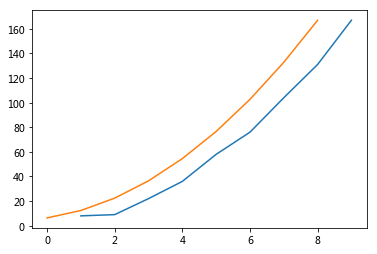

In [247]:
np.random.seed(0)
x=np.arange(1,10)
y=[2*z**2+np.random.randint(1,10) for z in a]
def func(x,a,b):
    y=a*x**2+b
    return y
popt, pcov=curve_fit(func,x,y)
popt
y_fitted=func(x,popt[0],popt[1])
y_fitted
popt
SSE=np.sum((y-y_fitted)**2)
SSR=np.sum((y_fitted-np.mean(y))**2)
SST=np.sum((y-np.mean(y))**2)
R_square=SSR/SST
plt.plot(a,a2,y_fitted)

In [3]:
data=pd.read_csv('/Users/rickie/Desktop/statistics_by_python/flights.csv')
data.head()

,year,month,passengers
0,1949,January,112
1,1949,February,118
2,1949,March,132
3,1949,April,129
4,1949,May,121


In [4]:
def concat(df):
    df['date']=str(df['year'])+' '+str(df['month'])
    return df
data=data.apply(concat,axis=1)
data.head()

,year,month,passengers,date
0,1949,January,112,1949 January
1,1949,February,118,1949 February
2,1949,March,132,1949 March
3,1949,April,129,1949 April
4,1949,May,121,1949 May


In [5]:
data['date']=data['date'].map(lambda x:datetime.strptime(x,'%Y %B'))
data.head()
data=data[['date','passengers']]
data.head()

,date,passengers
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121


In [6]:
data=data.set_index('date')
data.head()

,passengers
date,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


### 平稳性检验

/Users/rickie/anaconda3/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


Test Statistic                  0.815369
p-value                         0.991880
#lags used                     13.000000
Number of obervations used    130.000000
critical value (1%):           -3.481682
critical value (5%):           -2.884042
critical value (10%):          -2.578770
dtype: float64

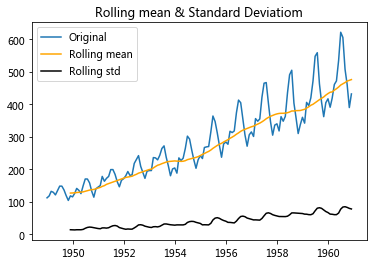

In [7]:

def stationality_test(ts,n):
    rolmean=pd.Series.rolling(ts,window=n).mean()
    rolstd=pd.Series.rolling(ts,window=n).std()
    orig=plt.plot(ts,label='Original')
    mean=plt.plot(rolmean,color='orange',label='Rolling mean')
    std=plt.plot(rolstd,color='black',label='Rolling std')
    plt.legend(loc='best')
    plt.title('Rolling mean & Standard Deviatiom')
    
    dftest=adfuller(ts,autolag='AIC')#原假设是存在单位根，拒绝原假设则时间序列平稳
    result=pd.Series(dftest[:4],index=['Test Statistic','p-value','#lags used','Number of obervations used'])
    for k,v in dftest[4].items():
        result['critical value (%s):'%k]=v
    return result
stationality_test(data['passengers'],12)
#可以看到，数据的rolling均值/标准差具有越来越大的趋势，是不稳定的。
#且DF-test可以明确的指出，在任何置信度下，数据都不是稳定的。

#### 去除趋势

Test Statistic                 -3.162908
p-value                         0.022235
#lags used                     13.000000
Number of obervations used    119.000000
critical value (1%):           -3.486535
critical value (5%):           -2.886151
critical value (10%):          -2.579896
dtype: float64

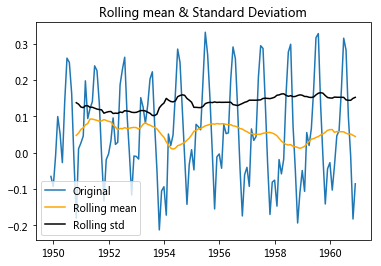

In [10]:
#为了使数值变化更明显
data_log=np.log(data['passengers'])
#1.平滑法：以一个滑动窗口内的均值代替原来的值，为了使值之间的差距缩小
rolmean=pd.Series.rolling(data_log,window=12).mean()
diff=data_log-rolmean
diff.dropna(inplace=True)
stationality_test(diff,12)    


Test Statistic                 -3.601262
p-value                         0.005737
#lags used                     13.000000
Number of obervations used    130.000000
critical value (1%):           -3.481682
critical value (5%):           -2.884042
critical value (10%):          -2.578770
dtype: float64

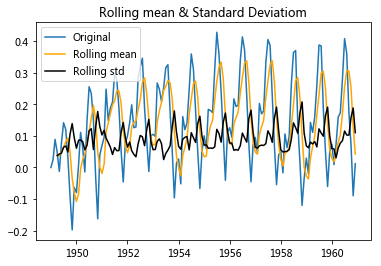

In [11]:
# halflife的值决定了衰减因子alpha：  alpha = 1 - exp(log(0.5) / halflife)
expweighted_avg = pd.DataFrame.ewm(data_log,halflife=12).mean()
diff1=data_log-expweighted_avg
diff1.dropna(inplace=True)
stationality_test(diff1,4)    

Test Statistic                 -2.717131
p-value                         0.071121
#lags used                     14.000000
Number of obervations used    128.000000
critical value (1%):           -3.482501
critical value (5%):           -2.884398
critical value (10%):          -2.578960
dtype: float64

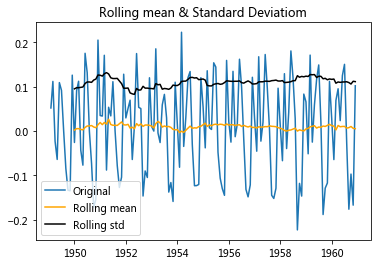

In [13]:
log_diff=data_log-data_log.shift()
log_diff.dropna(inplace=True)
stationality_test(log_diff,12)

Test Statistic                 -2.780749
p-value                         0.061077
#lags used                     12.000000
Number of obervations used    118.000000
critical value (1%):           -3.487022
critical value (5%):           -2.886363
critical value (10%):          -2.580009
dtype: float64

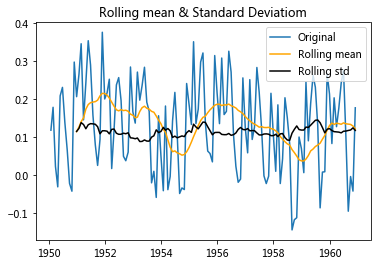

In [17]:
log_diff=data_log-data_log.shift(13)
log_diff.dropna(inplace=True)
stationality_test(log_diff,12)

### 季节性因素检验

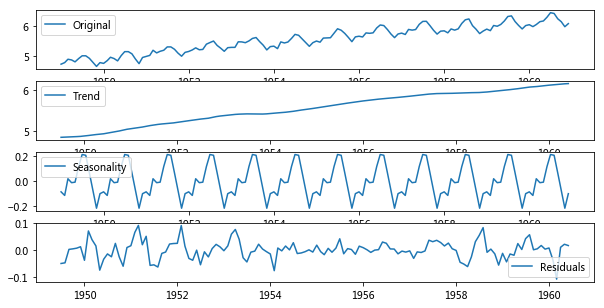

In [590]:
# 1.差分
# 2.seaonal_decompose
def season_plot(ts,n):
    decomposition=seasonal_decompose(ts,freq=n)
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid
    plt.figure(figsize=(10,5))
    plt.subplot(411)
    plt.plot(ts, label='Original')
    plt.legend(loc='best')
    plt.subplot(412)
    plt.plot(trend, label='Trend')
    plt.legend(loc='best')
    plt.subplot(413)
    plt.plot(seasonal,label='Seasonality')
    plt.legend(loc='best')
    plt.subplot(414)
    plt.plot(residual, label='Residuals')
    plt.legend(loc='best')
season_plot(data_log,12)

Test Statistic               -6.332387e+00
p-value                       2.885059e-08
#lags used                    9.000000e+00
Number of obervations used    1.220000e+02
critical value (1%):         -3.485122e+00
critical value (5%):         -2.885538e+00
critical value (10%):        -2.579569e+00
dtype: float64

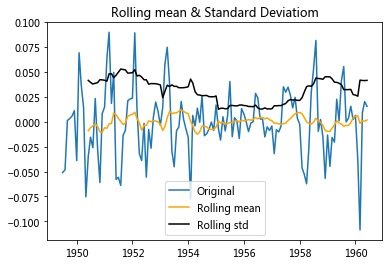

In [591]:
decomposition=seasonal_decompose(data_log,freq=12)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid
stationality_test(residual.dropna(),12)

#### 寻找ARIMA p,d,q的值

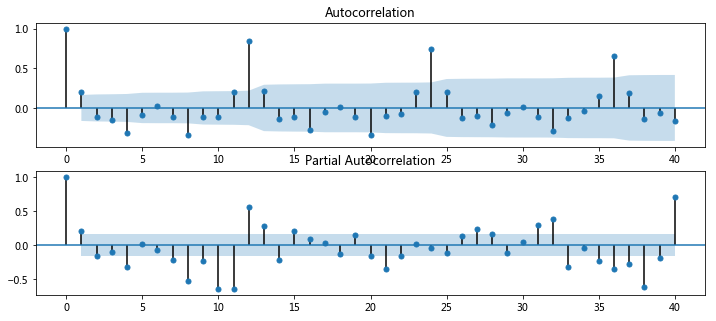

In [592]:
log_diff=data_log-data_log.shift()
log_diff.dropna(inplace=True)
lag_acf=acf(log_diff,nlags=20)
lag_pacf=pacf(log_diff,nlags=20,method='ols')
fig = plt.figure(figsize=(12,5))
ax1=fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(log_diff,lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(log_diff,lags=40,ax=ax2)



# plt.figure(figsize=(12,3))
# plt.subplot(121)
# plt.plot(lag_acf)
# plt.axhline(y=0,linestyle='--',color='gray')
# plt.axhline(y=1.96/np.sqrt(len(data)),linestyle='--',color='gray')
# plt.axhline(y=-1.96/np.sqrt(len(data)),linestyle='--',color='gray')
# plt.title('Autocorrelation Function')
# plt.subplot(122)
# plt.plot(lag_pacf)
# plt.axhline(y=0,linestyle='--',color='gray')
# plt.axhline(y=1.96/np.sqrt(len(data)),linestyle='--',color='gray')
# plt.axhline(y=-1.96/np.sqrt(len(data)),linestyle='--',color='gray')
# plt.title('Partial Autocorrelation Function')
# plt.tight_layout()

#### ARIMA model 

/Users/rickie/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/rickie/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:191: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  start=index[0], end=index[-1], freq=freq)
/Users/rickie/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Text(0.5, 1.0, 'RSS: 1.0292')

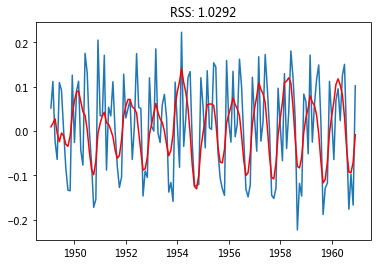

In [593]:
model = ARIMA(data_log, order=(2, 1, 2))  
results_ARIMA = model.fit(disp=-1)  
plt.plot(log_diff)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-log_diff)**2))

/Users/rickie/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/rickie/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Text(0.5, 1.0, 'RSS: 1.5023')

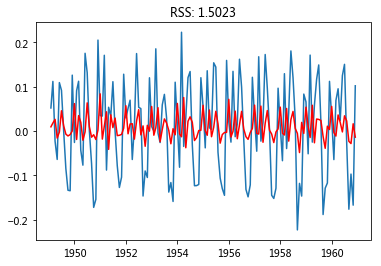

In [594]:
model = ARIMA(data_log, order=(2, 1, 0))  
results_AR = model.fit(disp=-1)  
plt.plot(log_diff)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-log_diff)**2))

/Users/rickie/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/rickie/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Text(0.5, 1.0, 'RSS: 1.4721')

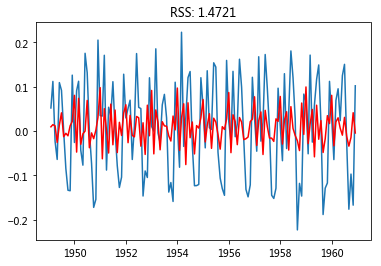

In [595]:
model = ARIMA(data_log, order=(0, 1, 2))  
results_MA = model.fit(disp=-1)  
plt.plot(log_diff)
plt.plot(results_MA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_MA.fittedvalues-log_diff)**2))

#### 由于ARIMA(2,1,2)的RSS最小，因此选择此模型

Text(0.5, 1.0, 'RMSE: 90.1046')

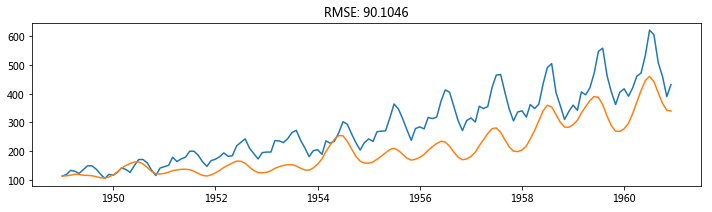

In [598]:
# fittedvalue为预测的差分值，即fitted[i]是Y[i]-Y[i-1]的值，因此，实际预测的F[i]=cumsum(i)+Y[1]
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
predictions_ARIMA_diff
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_log = pd.Series(data_log.iloc[0], index=data_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
#还原原数值
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.figure(figsize=(12,3))
plt.plot(data)
plt.plot(predictions_ARIMA)
plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA-data['passengers'])**2)/len(data)))